In [ ]:
import pandas as pd
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, GRU, Input
from sklearn.metrics import mean_squared_error, r2_score

Импорт необходимых библиотек

---



In [ ]:
 # Загрузка датасета
url = 'https://raw.githubusercontent.com/rzsprodigy/IAD/main/V4.csv'
df = pd.read_csv(url, index_col=0)
df.head()

,Customer Name,Customer e-mail,Country,Gender,Age,Annual Salary,Credit Card Debt,Net Worth,Car Purchase Amount
0,Martina Avila,cubilia.Curae.Phasellus@quisaccumsanconvallis.edu,USA,0.0,42,62812.09301,11609.380910,238961.2505,35321.45877
1,Harlan Barnes,eu.dolor@diam.co.uk,USA,0.0,41,66646.89292,9572.957136,530973.9078,45115.52566
2,Naomi Rodriquez,vulputate.mauris.sagittis@ametconsectetueradip...,USA,NaN,43,53798.55112,11160.355060,638467.1773,42925.70921
3,Jade Cunningham,malesuada@dignissim.com,USA,NaN,58,79370.03798,14426.164850,548599.0524,67422.36313
4,Cedric Leach,felis.ullamcorper.viverra@egetmollislectus.net,USA,1.0,57,59729.15130,5358.712177,560304.0671,55915.46248


Заргружаем датасет.

---



In [ ]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Customer Name        500 non-null    object 
 1   Customer e-mail      500 non-null    object 
 2   Country              500 non-null    object 
 3   Gender               244 non-null    float64
 4   Age                  500 non-null    int64  
 5   Annual Salary        500 non-null    float64
 6   Credit Card Debt     500 non-null    float64
 7   Net Worth            500 non-null    float64
 8   Car Purchase Amount  500 non-null    float64
dtypes: float64(5), int64(1), object(3)
memory usage: 39.1+ KB


,Gender,Age,Annual Salary,Credit Card Debt,Net Worth,Car Purchase Amount
count,244.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.500000,46.224000,62127.239608,9607.645049,431475.713625,44209.799218
std,0.501028,7.990339,11703.378228,3489.187973,173536.756340,10773.178744
min,0.000000,20.000000,20000.000000,100.000000,20000.000000,9000.000000
25%,0.000000,41.000000,54391.977195,7397.515792,299824.195900,37629.896040
50%,0.500000,46.000000,62915.497035,9655.035568,426750.120650,43997.783390
75%,1.000000,52.000000,70117.862005,11798.867487,557324.478725,51254.709517
max,1.000000,70.000000,100000.000000,20000.000000,1000000.000000,80000.000000


Эти данные описывают 500 клиентов среднего возраста (в основном 40–55 лет) с устойчивым уровнем дохода и умеренными кредитными обязательствами, которые обычно покупают автомобили стоимостью 38–51 тыс. долларов. Годовой доход относительно однородный (около 62 тыс.), тогда как чистая стоимость (капитал) клиентов отличается сильной разношёрстностью — от очень низких до очень высоких значений. Столбец Gender содержит большое количество пропусков, но в целом данные отражают клиентов со средним и выше среднего уровнем достатка.

**Описание датасета:**

Набор данных потенцильных покупателей автомобиля, в котором: 9 признаков, всего записей 500 (строк), одна строка представляет одного человека. 5 числовых признаков (Gender, Age, Annual Salary, Credit Card Debt, Net Worth), 3 текстовых признака (Customer Name, Customer e-mail, Country), целевой числовой признак (Car Purchase Amount).

**Задача:**

Построить регрессионную модель для целевого признака
«Car Purchase Amount» (сумма покупки автомобиля) от остальных входных
признаков.

---



Построим гистрограммы числовых признаков.

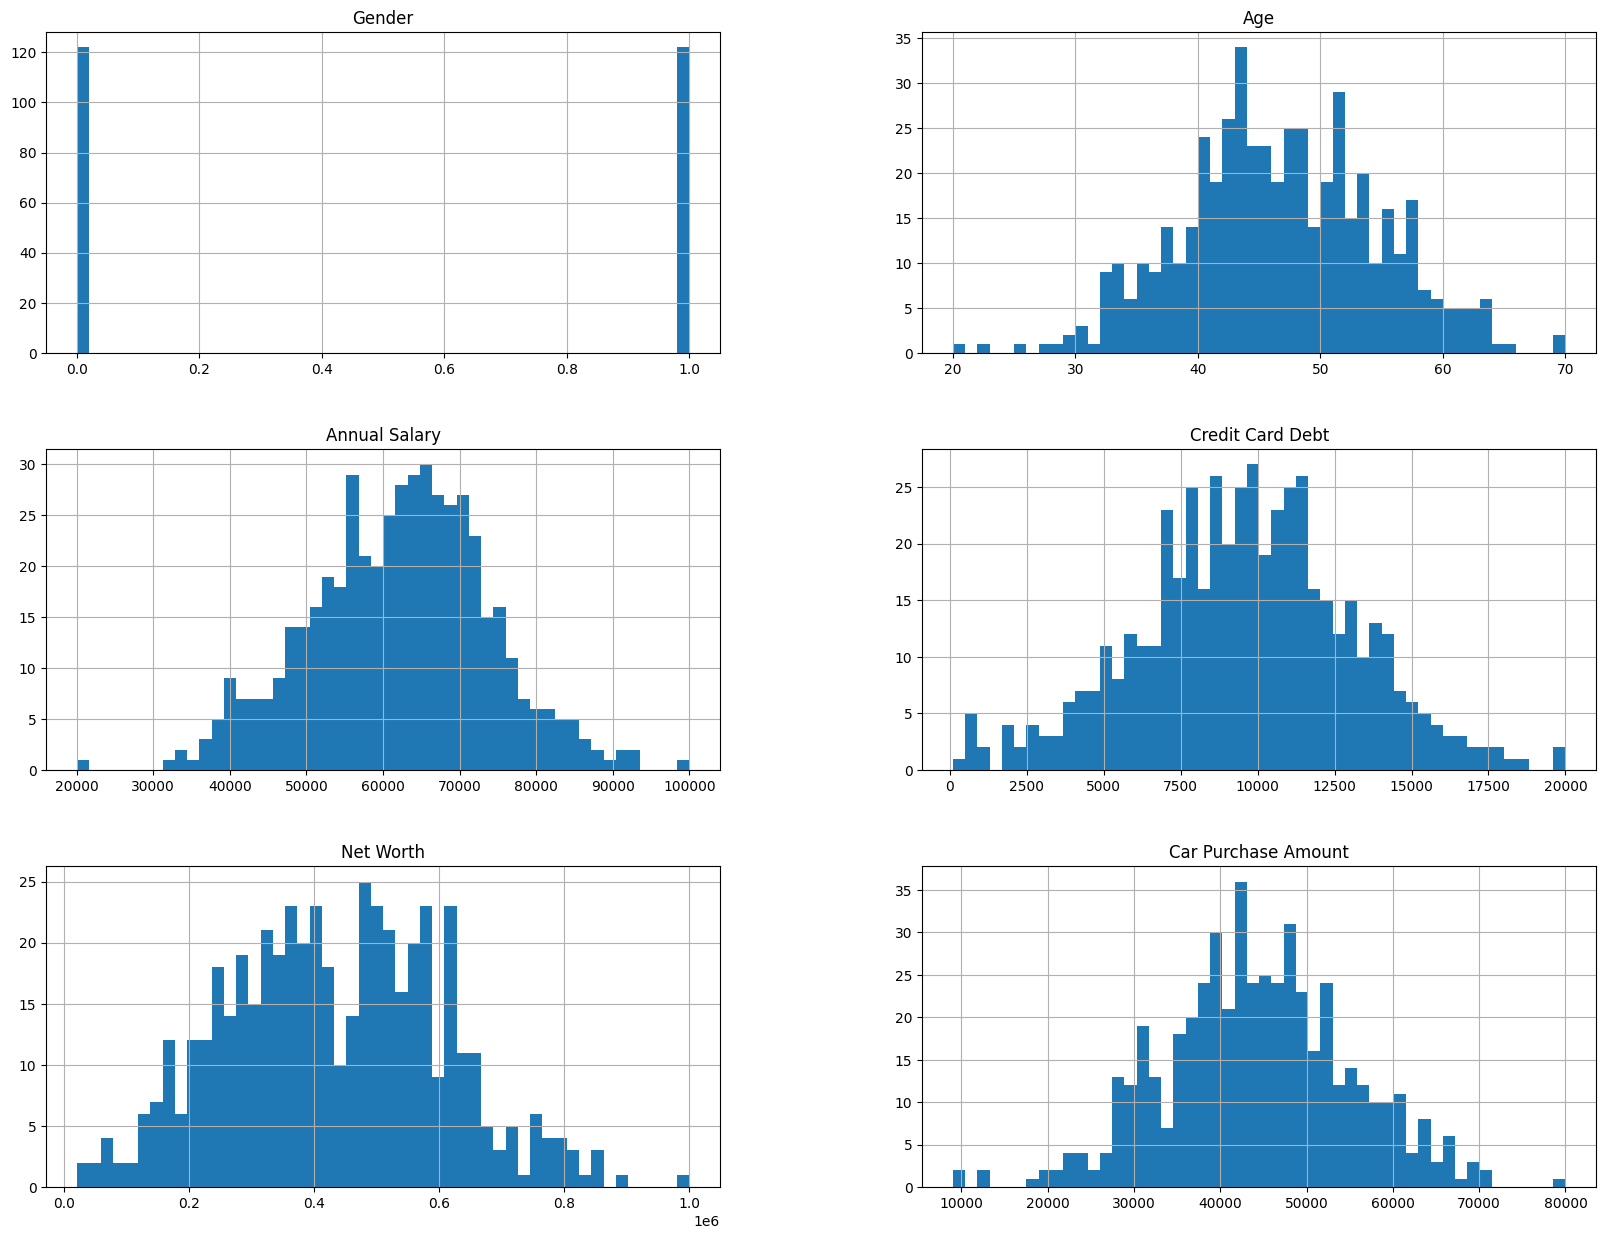

In [ ]:
df.hist(bins=50, figsize=(20,15))
plt.show()

По гистограммам можно сделать вывод, что данные в столбцах Annual Salary, Credit Card Debt, Net Worth и Car Purchase Ammount представленны в долларах США и в одном масштабе.

Построим графики плотности для признаков. Gender исключается, поскольку является бинарным и будет не информативен.

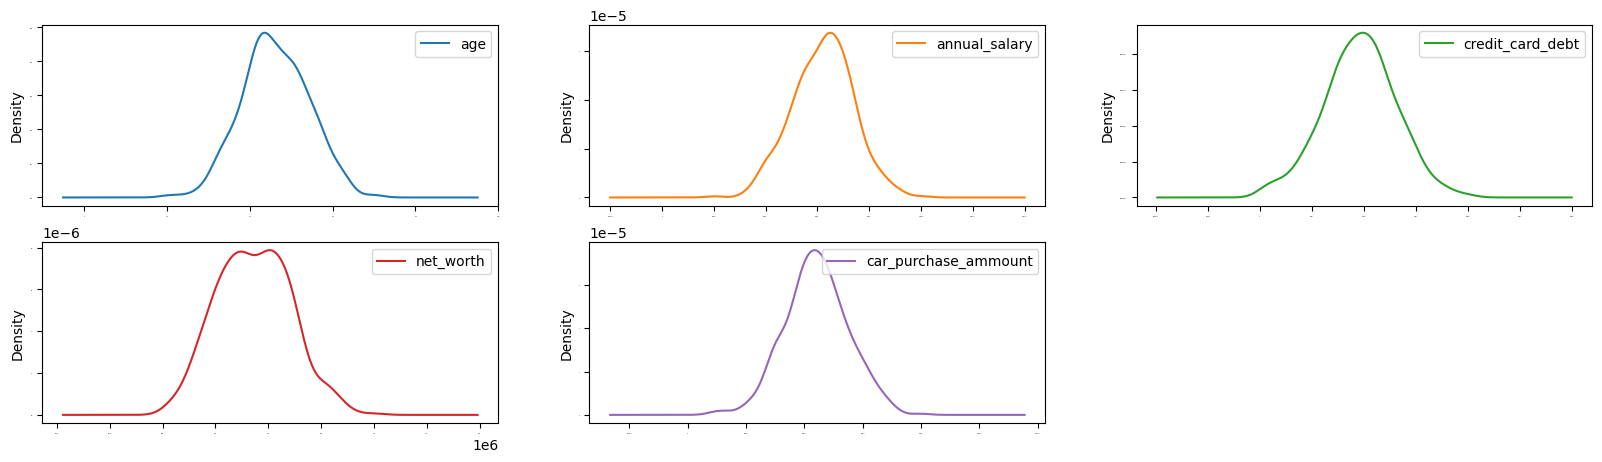

In [ ]:
age = df.Age
annual_salary = df['Annual Salary']
credit_card_debt = df['Credit Card Debt']
net_worth = df['Net Worth']
car_purchase_ammount = df['Car Purchase Amount']
sub_df = pd.DataFrame({'age': age,
                       'annual_salary': annual_salary,
                       'credit_card_debt': credit_card_debt,
                       'net_worth': net_worth,
                       'car_purchase_ammount': car_purchase_ammount})

sub_df.plot(kind='density', subplots=True, layout=(3,3), sharex=False, legend=True, fontsize=1, figsize=(20,8))
plt.show()

По гистограммам и графикам плотности можно сделать вывод, что распределение всех признаков, примерно соответствует нормальному.

---



Признаки Customer Name и Customer e-mail не влияют на целевой признак, поскольку являются текстовой информацией определенного покупателя.

Посмотрим признак Country, так как потенциально может оказывать влияние на целевой признак, поскольку от страны может зависеть и благосостояние человека.

In [ ]:
df['Country'].value_counts()

,count
Country,
USA,500


Признак Country имеет только одно значение, поэтому он не влияет на целевой признак.


---



In [ ]:
df= df.drop(['Customer Name', 'Customer e-mail', 'Country'], axis=1)
df

,Gender,Age,Annual Salary,Credit Card Debt,Net Worth,Car Purchase Amount
0,0.0,42,62812.09301,11609.380910,238961.2505,35321.45877
1,0.0,41,66646.89292,9572.957136,530973.9078,45115.52566
2,NaN,43,53798.55112,11160.355060,638467.1773,42925.70921
3,NaN,58,79370.03798,14426.164850,548599.0524,67422.36313
4,1.0,57,59729.15130,5358.712177,560304.0671,55915.46248
...,...,...,...,...,...,...
495,NaN,41,71942.40291,6995.902524,541670.1016,48901.44342
496,NaN,38,56039.49793,12301.456790,360419.0988,31491.41457
497,NaN,54,68888.77805,10611.606860,764531.3203,64147.28888
498,1.0,59,49811.99062,14013.034510,337826.6382,45442.15353


Избавляемся от признаков не влиющих на целевой признак.

---



Рассмотрим бинарный признак Gender, у которго имеются пропуски.

In [ ]:
df['Gender'].value_counts()

,count
Gender,
0.0,122
1.0,122


Два пола: 0 (женский), 1 (мужской).

Заполним пропуски случайными значениями (0 или 1)

In [ ]:
df['Gender'] = df['Gender'].apply(lambda x: 1 if pd.isna(x) and random.random() < 0.5 else (0 if pd.isna(x) else x))
print(df['Gender'].value_counts())


Gender
0.0    265
1.0    235
Name: count, dtype: int64




---

Построим корреляционную матрицу и матрицу диаграммы рассеяния.

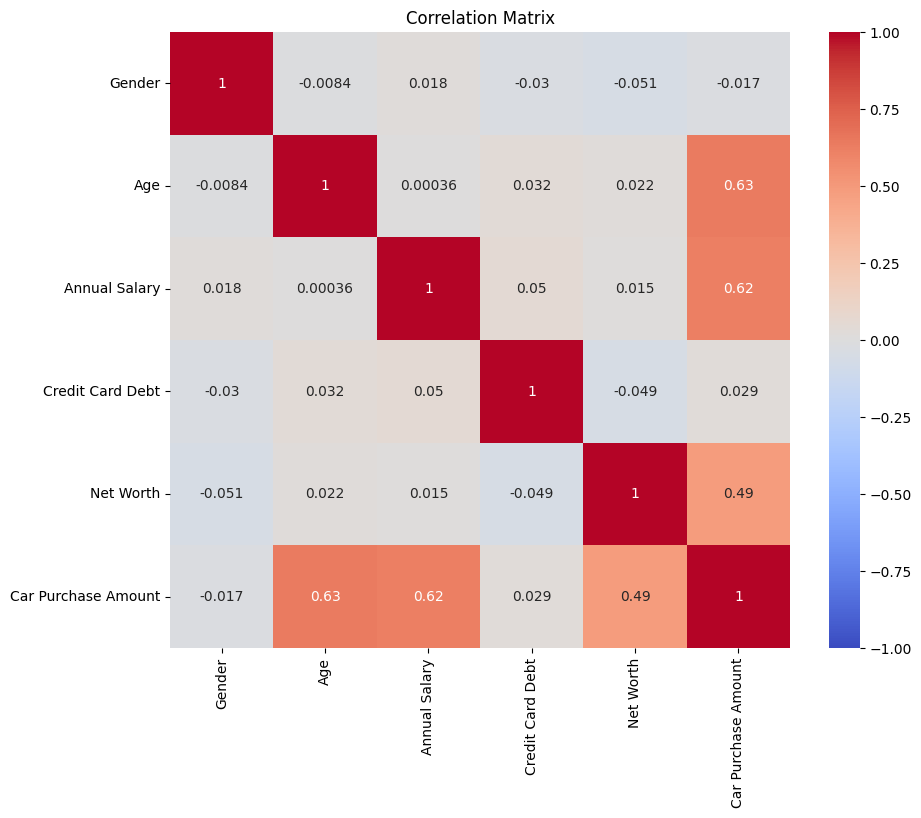

In [ ]:
plt.figure(figsize=(10, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

array([[<Axes: xlabel='age', ylabel='age'>,
        <Axes: xlabel='annual_salary', ylabel='age'>,
        <Axes: xlabel='credit_card_debt', ylabel='age'>,
        <Axes: xlabel='net_worth', ylabel='age'>,
        <Axes: xlabel='car_purchase_ammount', ylabel='age'>],
       [<Axes: xlabel='age', ylabel='annual_salary'>,
        <Axes: xlabel='annual_salary', ylabel='annual_salary'>,
        <Axes: xlabel='credit_card_debt', ylabel='annual_salary'>,
        <Axes: xlabel='net_worth', ylabel='annual_salary'>,
        <Axes: xlabel='car_purchase_ammount', ylabel='annual_salary'>],
       [<Axes: xlabel='age', ylabel='credit_card_debt'>,
        <Axes: xlabel='annual_salary', ylabel='credit_card_debt'>,
        <Axes: xlabel='credit_card_debt', ylabel='credit_card_debt'>,
        <Axes: xlabel='net_worth', ylabel='credit_card_debt'>,
        <Axes: xlabel='car_purchase_ammount', ylabel='credit_card_debt'>],
       [<Axes: xlabel='age', ylabel='net_worth'>,
        <Axes: xlabel='annual_sala

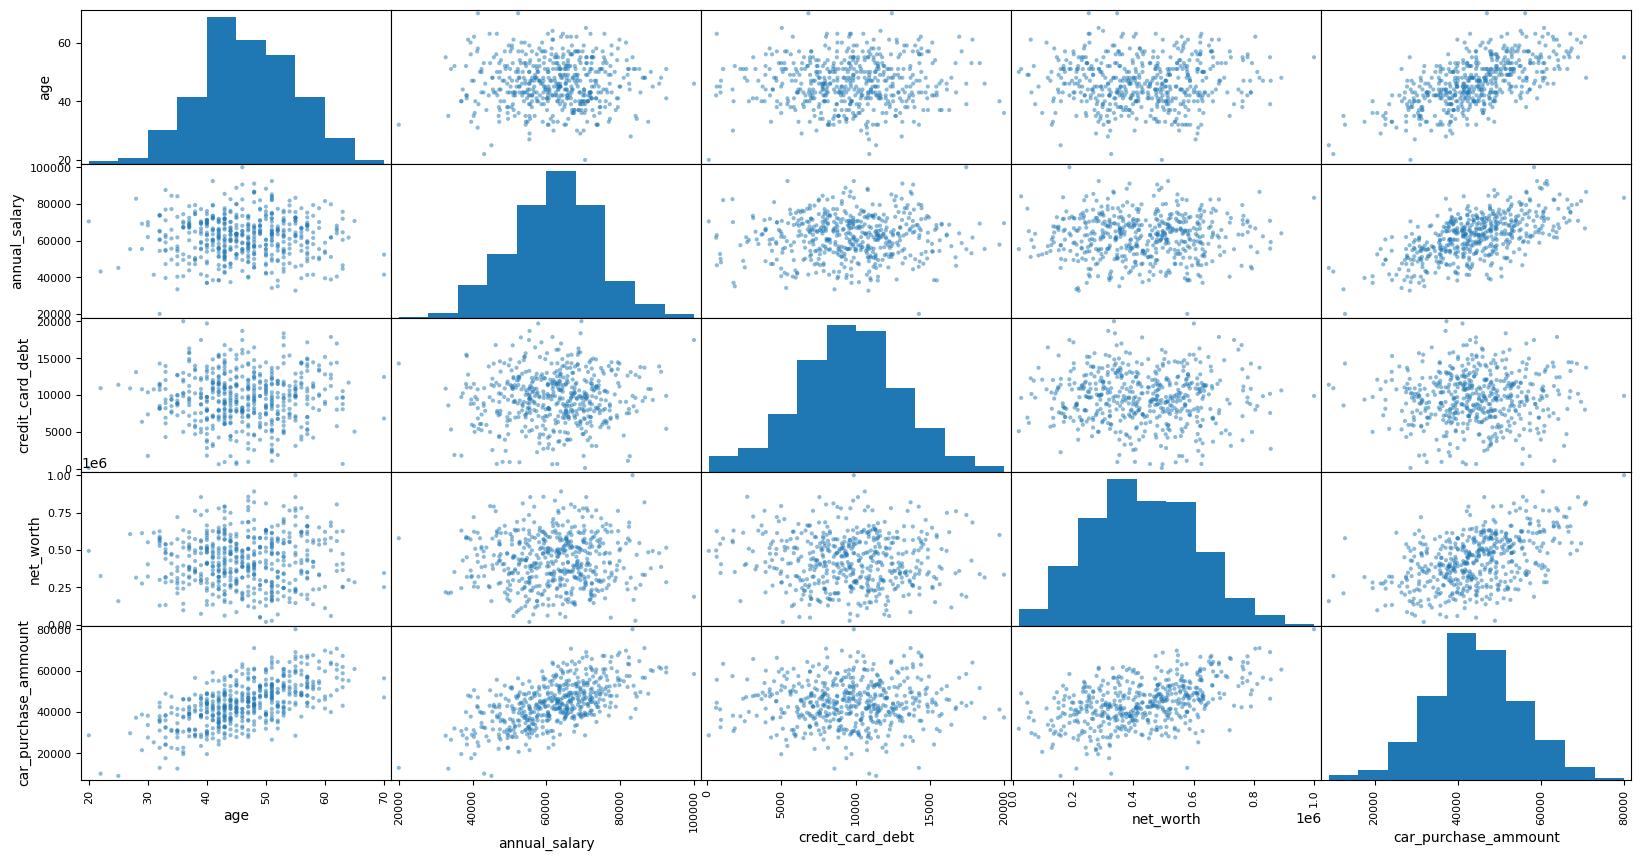

In [ ]:
scatter_matrix(sub_df, figsize=(20,10))

In [ ]:
corr_matrix

,Gender,Age,Annual Salary,Credit Card Debt,Net Worth,Car Purchase Amount
Gender,1.000000,-0.008353,0.018500,-0.029522,-0.051162,-0.017446
Age,-0.008353,1.000000,0.000361,0.031748,0.021794,0.633273
Annual Salary,0.018500,0.000361,1.000000,0.049599,0.014767,0.617862
Credit Card Debt,-0.029522,0.031748,0.049599,1.000000,-0.049378,0.028882
Net Worth,-0.051162,0.021794,0.014767,-0.049378,1.000000,0.488580
Car Purchase Amount,-0.017446,0.633273,0.617862,0.028882,0.488580,1.000000


In [ ]:
print("Корреляция с целевой переменной:")
print(corr_matrix['Car Purchase Amount'].sort_values(ascending=False))

Корреляция с целевой переменной:
Car Purchase Amount    1.000000
Age                    0.633273
Annual Salary          0.617862
Net Worth              0.488580
Credit Card Debt       0.028882
Gender                -0.017446
Name: Car Purchase Amount, dtype: float64


Целевой признак слабо зависит от атрибутов Gender и Credit Card Debt. Присутствует сильная положительная зависимость от атрибутов Age и Annual Salary, а также хорошая положительная зависимость с Net Worth.

---



Избавимся от слабо влияющих признаков Gender и Credit Card Debt.

In [ ]:
df= df.drop(['Gender', 'Credit Card Debt'], axis=1)
df

,Age,Annual Salary,Net Worth,Car Purchase Amount
0,42,62812.09301,238961.2505,35321.45877
1,41,66646.89292,530973.9078,45115.52566
2,43,53798.55112,638467.1773,42925.70921
3,58,79370.03798,548599.0524,67422.36313
4,57,59729.15130,560304.0671,55915.46248
...,...,...,...,...
495,41,71942.40291,541670.1016,48901.44342
496,38,56039.49793,360419.0988,31491.41457
497,54,68888.77805,764531.3203,64147.28888
498,59,49811.99062,337826.6382,45442.15353


Длбавим новые признаки в датасет.

In [ ]:
df["financial_independence"] = df["Net Worth"]/df["Annual Salary"]
df["salary_wealth"] = df["Annual Salary"]/df["Net Worth"]
df["net_woth_per_year"] = df["Net Worth"]/df["Age"]
df

,Age,Annual Salary,Net Worth,Car Purchase Amount,financial_independence,salary_wealth,net_woth_per_year
0,42,62812.09301,238961.2505,35321.45877,3.804383,0.262855,5689.553583
1,41,66646.89292,530973.9078,45115.52566,7.966972,0.125518,12950.583117
2,43,53798.55112,638467.1773,42925.70921,11.867739,0.084262,14848.073891
3,58,79370.03798,548599.0524,67422.36313,6.911916,0.144678,9458.604352
4,57,59729.15130,560304.0671,55915.46248,9.380747,0.106601,9829.895914
...,...,...,...,...,...,...,...
495,41,71942.40291,541670.1016,48901.44342,7.529219,0.132816,13211.465893
496,38,56039.49793,360419.0988,31491.41457,6.431519,0.155484,9484.713126
497,54,68888.77805,764531.3203,64147.28888,11.098053,0.090106,14157.987413
498,59,49811.99062,337826.6382,45442.15353,6.782034,0.147448,5725.875224


financial_independence - количество лет, которое человек может прожить на текущие накопления, сохраняя текущий уровень расходов.

salary_wealth - доля годового дохода от общего состояния.

net_woth_per_year - среднегодовая сумма накоплений за всю жизнь.

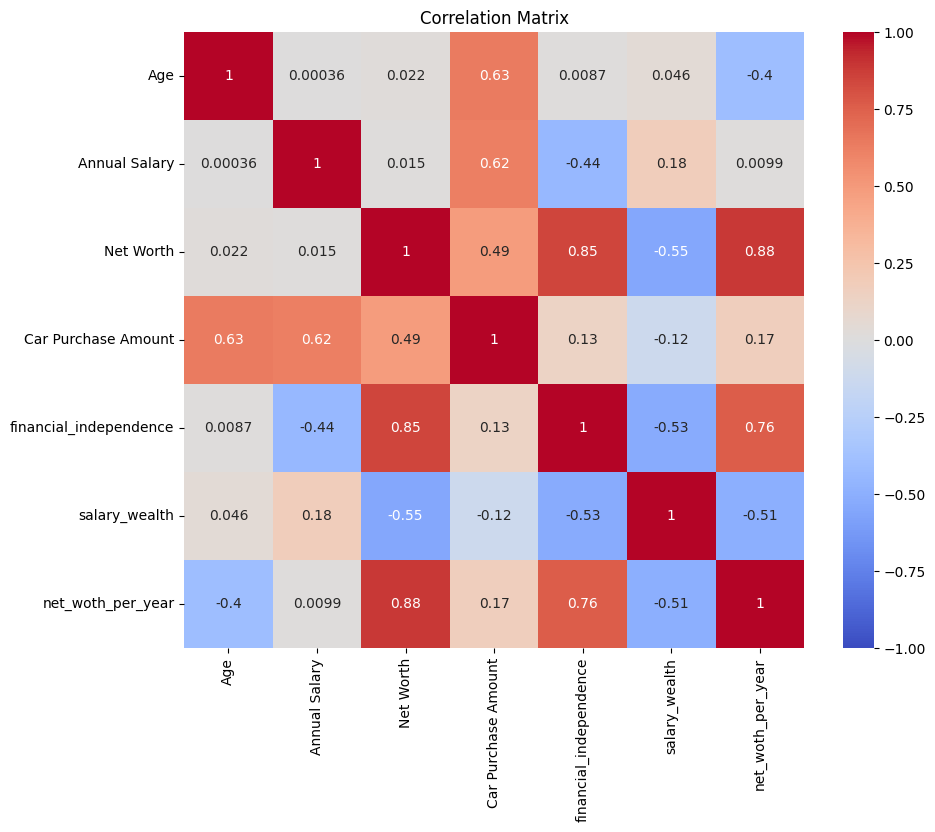

Корреляция с целевой переменной:
Car Purchase Amount       1.000000
Age                       0.633273
Annual Salary             0.617862
Net Worth                 0.488580
net_woth_per_year         0.167600
financial_independence    0.129941
salary_wealth            -0.118293
Name: Car Purchase Amount, dtype: float64


In [ ]:
plt.figure(figsize=(10, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

print("Корреляция с целевой переменной:")
print(corr_matrix['Car Purchase Amount'].sort_values(ascending=False))

Добавленные атрибуты имеют влияние на целевой признак.

Это наш исходный датасет.

---



Создадим построенный датасет, отобрав существенные признаки.

In [ ]:
strong_features = ['Age', 'Annual Salary', 'Net Worth']
target = 'Car Purchase Amount'

df_constructed = df[strong_features + [target]].copy()



---

Отделим целевой признак от атрибутов.

In [ ]:
X = df.drop(['Car Purchase Amount'], axis=1)
Y = df['Car Purchase Amount']

X_constructed = df_constructed.drop(['Car Purchase Amount'], axis=1)
Y_constructed = df_constructed['Car Purchase Amount']

Используя MinMaxScaler выполним масштабирование построенного и исходного датасета в диапазон от 0 до 1

In [ ]:
scaler = MinMaxScaler(feature_range = (0, 1))

X_scaled = scaler.fit_transform(X)
Y_scaled = scaler.fit_transform(Y.values.reshape(-1, 1))

X_constructed_scaled = scaler.fit_transform(X_constructed)
Y_constructed_scaled = scaler.fit_transform(Y_constructed.values.reshape(-1, 1))

print(X_scaled)

[[0.44       0.53515116 0.22342985 0.12131151 0.07657297 0.21740573]
 [0.42       0.58308616 0.52140195 0.2667165  0.0305143  0.51584102]
 [0.46       0.42248189 0.63108896 0.40297571 0.01667818 0.59382971]
 ...
 [0.68       0.61110973 0.75972584 0.37608951 0.01863804 0.5654665 ]
 [0.78       0.37264988 0.3243129  0.225325   0.03786904 0.21889859]
 [0.54       0.51713347 0.45198622 0.25192222 0.03287772 0.38840101]]


Разделим наборы данных (исходный, исходный преобразованноый, построенный, построенный преобразованный) на обучающую, валидационную и тестовую выборки.

Размер обучающей выборки 60%, валидационной и тестовой по 20%. Значения были выбраны с учётом размера датасета, который состоит из 500 записей и является относительно небольшим.

In [ ]:
# Разделяем исходный датасет на обучающую и тестовую выборки 60/40
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=42)
# Разделяем тестовую выборку на тестовую и валидационную 50/50 (так как тестовая 40% от исходного датасета)
X_test, X_dev, Y_test, Y_dev = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)

# Разделяем исходный преобразованный датасет на обучающую и тестовую выборки 60/40
X_scaled_train, X_scaled_test, Y_scaled_train, Y_scaled_test = train_test_split(X_scaled, Y_scaled, test_size=0.4, random_state=42)
# Разделяем тестовую выборку на тестовую и валидационную 50/50 (так как тестовая 40% от исходного датасета)
X_scaled_test, X_scaled_dev, Y_scaled_test, Y_scaled_dev = train_test_split(X_scaled_test, Y_scaled_test, test_size=0.5, random_state=42)

# Разделяем построенный датасет на обучающую и тестовую выборки 60/40
X_constructed_train, X_constructed_test, Y_constructed_train, Y_constructed_test = train_test_split(X_constructed, Y_constructed, test_size=0.4, random_state=42)
# Разделяем тестовую выборку на тестовую и валидационную 50/50 (так как тестовая 40% от исходного датасета)
X_constructed_test, X_constructed_dev, Y_constructed_test, Y_constructed_dev = train_test_split(X_constructed_test, Y_constructed_test, test_size=0.5, random_state=42)

# Разделяем построенный преобразованный датасет на обучающую и тестовую выборки 60/40
X_constructed_scaled_train, X_constructed_scaled_test, Y_constructed_scaled_train, Y_constructed_scaled_test = train_test_split(
    X_constructed_scaled, Y_constructed_scaled, test_size=0.4, random_state=42)
# Разделяем тестовую выборку на тестовую и валидационную 50/50 (так как тестовая 40% от исходного датасета)
X_constructed_scaled_test, X_constructed_scaled_dev, Y_constructed_scaled_test, Y_constructed_scaled_dev = train_test_split(
    X_constructed_scaled_test, Y_constructed_scaled_test, test_size=0.5, random_state=42)



---

Создадим 8 моделей: 4 датасета по 2 модели (полносвязная нейросетевая, GRU рекуррентная сеть).

Модели:

**dense_model** - полносвязная модель для исходного датасета,

**gru_model** - рекурентная модель с GRU блоками для исходного датасета,

**dense_model_scaled** - полносвязная модель для исходного преобразованного датасета,

**gru_model_scaled** - рекурентная модель с GRU блоками для исходного преобразованного датасета,

**dense_model_constructed** - полносвязная модель для построенного датасета,

**gru_model_constructed** - рекурентная модель с GRU блоками для построенного датасета,

**dense_model_constructed_scaled** - полносвязная модель для построенного преобразованного датасета,

**gru_model_constructed_scaled** - рекурентная модель с GRU блоками для построенного преобразованного датасета.

In [ ]:
print("ИСХОДНЫЙ ДАТАСЕТ - ПОЛНОСВЯЗНАЯ")
# Полносвязная нейросеть
dense_model = Sequential()
dense_model.add(Input(shape=(X_train.shape[1],)))
dense_model.add(Dense(64, activation='relu'))
dense_model.add(Dense(32, activation='relu'))
dense_model.add(Dense(16, activation='relu'))
dense_model.add(Dense(1))
dense_model.compile(optimizer='adam', loss='mean_squared_error')

history = dense_model.fit(
    X_train, Y_train,
    validation_data=(X_dev, Y_dev),
    epochs=100,
    batch_size=16,
    verbose=0
)

# Берем финальные loss из history и вычисляем RMSE
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
train_rmse_dense = np.sqrt(final_train_loss)
dev_rmse_dense = np.sqrt(final_val_loss)

# Для R^2 делаем предсказания
train_r2_dense = r2_score(Y_train, dense_model.predict(X_train).flatten())
dev_r2_dense = r2_score(Y_dev, dense_model.predict(X_dev).flatten())

print(f"Полносвязная - Train RMSE: {train_rmse_dense}, R^2: {train_r2_dense}")
print(f"Полносвязная - Dev RMSE: {dev_rmse_dense}, R^2: {dev_r2_dense}")

ИСХОДНЫЙ ДАТАСЕТ - ПОЛНОСВЯЗНАЯ
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Полносвязная - Train RMSE: 3517.290292256242, R^2: 0.8957665739886829
Полносвязная - Dev RMSE: 3686.5729343117573, R^2: 0.892908605546104


In [ ]:
print("ИСХОДНЫЙ ДАТАСЕТ - GRU НЕЙРОСЕТЬ")
# GRU нейросеть
X_train_gru = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_dev_gru = X_dev.values.reshape((X_dev.shape[0], 1, X_dev.shape[1]))

gru_model = Sequential()
gru_model.add(Input(shape=(1, X_train.shape[1])))
gru_model.add(GRU(64, return_sequences=True))
gru_model.add(GRU(32, return_sequences=True))
gru_model.add(GRU(16))
gru_model.add(Dense(1))
gru_model.compile(optimizer='adam', loss='mean_squared_error')

history_gru = gru_model.fit(
    X_train_gru, Y_train,
    validation_data=(X_dev_gru, Y_dev),
    epochs=100,
    batch_size=32,
    verbose=0
)

# Берем финальные loss из history и вычисляем RMSE
final_train_loss = history_gru.history['loss'][-1]
final_val_loss = history_gru.history['val_loss'][-1]
train_rmse_gru = np.sqrt(final_train_loss)
dev_rmse_gru = np.sqrt(final_val_loss)

# Для R^2 делаем предсказания
train_r2_gru = r2_score(Y_train, gru_model.predict(X_train_gru).flatten())
dev_r2_gru = r2_score(Y_dev, gru_model.predict(X_dev_gru).flatten())

print(f"GRU нейросеть - Train RMSE: {train_rmse_gru}, R^2: {train_r2_gru}")
print(f"GRU нейросеть - Dev RMSE: {dev_rmse_gru}, R^2: {dev_r2_gru}")

ИСХОДНЫЙ ДАТАСЕТ - GRU НЕЙРОСЕТЬ
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
GRU нейросеть - Train RMSE: 44921.60495797095, R^2: -16.93210756958416
GRU нейросеть - Dev RMSE: 47555.90293538753, R^2: -16.82041948276431


In [ ]:
print("ИСХОДНЫЙ ПРЕОБРАЗОВАННЫЙ ДАТАСЕТ - ПОЛНОСВЯЗНАЯ")
# Полносвязная нейросеть
dense_model_scaled = Sequential()
dense_model_scaled.add(Input(shape=(X_scaled_train.shape[1],)))
dense_model_scaled.add(Dense(64, activation='relu'))
dense_model_scaled.add(Dense(32, activation='relu'))
dense_model_scaled.add(Dense(16, activation='relu'))
dense_model_scaled.add(Dense(1))
dense_model_scaled.compile(optimizer='adam', loss='mean_squared_error')

history_scaled = dense_model_scaled.fit(
    X_scaled_train, Y_scaled_train,
    validation_data=(X_scaled_dev, Y_scaled_dev),
    epochs=100,
    batch_size=16,
    verbose=0
)

# Предсказания на обучающей и валидационной выборках
train_pred_scaled = dense_model_scaled.predict(X_scaled_train).flatten()
dev_pred_scaled = dense_model_scaled.predict(X_scaled_dev).flatten()

# Обратное преобразование к исходной шкале
train_pred_original = scaler.inverse_transform(train_pred_scaled.reshape(-1, 1)).flatten()
dev_pred_original = scaler.inverse_transform(dev_pred_scaled.reshape(-1, 1)).flatten()

# RMSE в исходной шкале
train_rmse_original = np.sqrt(np.mean((Y_train.values - train_pred_original) ** 2))
dev_rmse_original = np.sqrt(np.mean((Y_dev.values - dev_pred_original) ** 2))

# Для R^2 оставляем на масштабированных данных
train_r2_scaled = r2_score(Y_scaled_train, train_pred_scaled)
dev_r2_scaled = r2_score(Y_scaled_dev, dev_pred_scaled)

print(f"Полносвязная - Train RMSE (исходная шкала): {train_rmse_original}, R^2: {train_r2_scaled}")
print(f"Полносвязная - Dev RMSE (исходная шкала): {dev_rmse_original}, R^2: {dev_r2_scaled}")


ИСХОДНЫЙ ПРЕОБРАЗОВАННЫЙ ДАТАСЕТ - ПОЛНОСВЯЗНАЯ
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Полносвязная - Train RMSE (исходная шкала): 485.83875451687544, R^2: 0.9979024814225451
Полносвязная - Dev RMSE (исходная шкала): 674.5245544467667, R^2: 0.9964148779729801


In [ ]:
print("ИСХОДНЫЙ ПРЕОБРАЗОВАННЫЙ ДАТАСЕТ - GRU НЕЙРОСЕТЬ")
# Подготовка данных для GRU
X_scaled_train_gru = X_scaled_train.reshape((X_scaled_train.shape[0], 1, X_scaled_train.shape[1]))
X_scaled_dev_gru = X_scaled_dev.reshape((X_scaled_dev.shape[0], 1, X_scaled_dev.shape[1]))

# Создаем модель GRU
gru_model_scaled = Sequential()
gru_model_scaled.add(Input(shape=(1, X_scaled_train.shape[1])))
gru_model_scaled.add(GRU(64, return_sequences=True))
gru_model_scaled.add(GRU(32, return_sequences=True))
gru_model_scaled.add(GRU(16))
gru_model_scaled.add(Dense(1))
gru_model_scaled.compile(optimizer='adam', loss='mean_squared_error')

# Обучение модели
history_gru_scaled = gru_model_scaled.fit(
    X_scaled_train_gru, Y_scaled_train,
    validation_data=(X_scaled_dev_gru, Y_scaled_dev),
    epochs=100,
    batch_size=32,
    verbose=0
)

# Предсказания на тренировочной и валидационной выборках
train_pred_scaled = gru_model_scaled.predict(X_scaled_train_gru).flatten()
dev_pred_scaled = gru_model_scaled.predict(X_scaled_dev_gru).flatten()

# Обратное преобразование к исходной шкале
train_pred_original = scaler.inverse_transform(train_pred_scaled.reshape(-1,1)).flatten()
dev_pred_original = scaler.inverse_transform(dev_pred_scaled.reshape(-1,1)).flatten()

# RMSE в исходной шкале
train_rmse_original = np.sqrt(np.mean((Y_train.values - train_pred_original) ** 2))
dev_rmse_original = np.sqrt(np.mean((Y_dev.values - dev_pred_original) ** 2))

# R^2 оставляем на масштабированных данных
train_r2_scaled = r2_score(Y_scaled_train, train_pred_scaled)
dev_r2_scaled = r2_score(Y_scaled_dev, dev_pred_scaled)

print(f"GRU нейросеть - Train RMSE (исходная шкала): {train_rmse_original}, R^2: {train_r2_scaled}")
print(f"GRU нейросеть - Dev RMSE (исходная шкала): {dev_rmse_original}, R^2: {dev_r2_scaled}")


ИСХОДНЫЙ ПРЕОБРАЗОВАННЫЙ ДАТАСЕТ - GRU НЕЙРОСЕТЬ
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
GRU нейросеть - Train RMSE (исходная шкала): 381.2276131200447, R^2: 0.9987085099647007
GRU нейросеть - Dev RMSE (исходная шкала): 467.2024747214985, R^2: 0.9982800381022238


In [ ]:
print("ПОСТРОЕННЫЙ ДАТАСЕТ - ПОЛНОСВЯЗНАЯ")
# Полносвязная нейросеть
dense_model_constructed = Sequential()
dense_model_constructed.add(Input(shape=(X_constructed_train.shape[1],)))
dense_model_constructed.add(Dense(64, activation='relu'))
dense_model_constructed.add(Dense(32, activation='relu'))
dense_model_constructed.add(Dense(16, activation='relu'))
dense_model_constructed.add(Dense(1))
dense_model_constructed.compile(optimizer='adam', loss='mean_squared_error')

history_constructed = dense_model_constructed.fit(
    X_constructed_train, Y_constructed_train,
    validation_data=(X_constructed_dev, Y_constructed_dev),
    epochs=100,
    batch_size=16,
    verbose=0
)

# Берем финальные loss из history и вычисляем RMSE
final_train_loss = history_constructed.history['loss'][-1]
final_val_loss = history_constructed.history['val_loss'][-1]
train_rmse_dense_constructed = np.sqrt(final_train_loss)
dev_rmse_dense_constructed = np.sqrt(final_val_loss)

# Для R^2 делаем предсказания
train_r2_dense_constructed = r2_score(Y_constructed_train, dense_model_constructed.predict(X_constructed_train).flatten())
dev_r2_dense_constructed = r2_score(Y_constructed_dev, dense_model_constructed.predict(X_constructed_dev).flatten())

print(f"Полносвязная - Train RMSE: {train_rmse_dense_constructed}, R^2: {train_r2_dense_constructed}")
print(f"Полносвязная - Dev RMSE: {dev_rmse_dense_constructed}, R^2: {dev_r2_dense_constructed}")

ПОСТРОЕННЫЙ ДАТАСЕТ - ПОЛНОСВЯЗНАЯ
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Полносвязная - Train RMSE: 6484.625201197059, R^2: 0.6158588611836451
Полносвязная - Dev RMSE: 7589.77259211368, R^2: 0.5460932985561401


In [ ]:
print("ПОСТРОЕННЫЙ ДАТАСЕТ - GRU НЕЙРОСЕТЬ")
# GRU нейросеть
X_constructed_train_gru = X_constructed_train.values.reshape((X_constructed_train.shape[0], 1, X_constructed_train.shape[1]))
X_constructed_dev_gru = X_constructed_dev.values.reshape((X_constructed_dev.shape[0], 1, X_constructed_dev.shape[1]))

gru_model_constructed = Sequential()
gru_model_constructed.add(Input(shape=(1, X_constructed_train.shape[1])))
gru_model_constructed.add(GRU(64, return_sequences=True))
gru_model_constructed.add(GRU(32, return_sequences=True))
gru_model_constructed.add(GRU(16))
gru_model_constructed.add(Dense(1))
gru_model_constructed.compile(optimizer='adam', loss='mean_squared_error')

history_gru_constructed = gru_model_constructed.fit(
    X_constructed_train_gru, Y_constructed_train,
    validation_data=(X_constructed_dev_gru, Y_constructed_dev),
    epochs=100,
    batch_size=32,
    verbose=0
)

# Берем финальные loss из history и вычисляем RMSE
final_train_loss = history_gru_constructed.history['loss'][-1]
final_val_loss = history_gru_constructed.history['val_loss'][-1]
train_rmse_gru_constructed = np.sqrt(final_train_loss)
dev_rmse_gru_constructed = np.sqrt(final_val_loss)

# Для R^2 делаем предсказания
train_r2_gru_constructed = r2_score(Y_constructed_train, gru_model_constructed.predict(X_constructed_train_gru).flatten())
dev_r2_gru_constructed = r2_score(Y_constructed_dev, gru_model_constructed.predict(X_constructed_dev_gru).flatten())

print(f"GRU нейросеть - Train RMSE: {train_rmse_gru_constructed}, R^2: {train_r2_gru_constructed}")
print(f"GRU нейросеть - Dev RMSE: {dev_rmse_gru_constructed}, R^2: {dev_r2_gru_constructed}")

ПОСТРОЕННЫЙ ДАТАСЕТ - GRU НЕЙРОСЕТЬ
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
GRU нейросеть - Train RMSE: 44921.49098148903, R^2: -16.932019018035536
GRU нейросеть - Dev RMSE: 47555.82487981887, R^2: -16.820360201161655


In [ ]:
print("ПОСТРОЕННЫЙ ПРЕОБРАЗОВАННЫЙ ДАТАСЕТ - ПОЛНОСВЯЗНАЯ")
# Полносвязная нейросеть
dense_model_constructed_scaled = Sequential()
dense_model_constructed_scaled.add(Input(shape=(X_constructed_scaled_train.shape[1],)))
dense_model_constructed_scaled.add(Dense(64, activation='relu'))
dense_model_constructed_scaled.add(Dense(32, activation='relu'))
dense_model_constructed_scaled.add(Dense(16, activation='relu'))
dense_model_constructed_scaled.add(Dense(1))
dense_model_constructed_scaled.compile(optimizer='adam', loss='mean_squared_error')

# Обучение модели
history_constructed_scaled = dense_model_constructed_scaled.fit(
    X_constructed_scaled_train, Y_constructed_scaled_train,
    validation_data=(X_constructed_scaled_dev, Y_constructed_scaled_dev),
    epochs=100,
    batch_size=16,
    verbose=0
)

# Предсказания на обучающей и валидационной выборках
train_pred_scaled = dense_model_constructed_scaled.predict(X_constructed_scaled_train).flatten()
dev_pred_scaled = dense_model_constructed_scaled.predict(X_constructed_scaled_dev).flatten()

# Обратное преобразование к исходной шкале
train_pred_original = scaler.inverse_transform(train_pred_scaled.reshape(-1,1)).flatten()
dev_pred_original = scaler.inverse_transform(dev_pred_scaled.reshape(-1,1)).flatten()

# RMSE в исходной шкале
train_rmse_original = np.sqrt(np.mean((Y_constructed_train.values - train_pred_original) ** 2))
dev_rmse_original = np.sqrt(np.mean((Y_constructed_dev.values - dev_pred_original) ** 2))

# R^2 на масштабированных данных
train_r2_scaled = r2_score(Y_constructed_scaled_train, train_pred_scaled)
dev_r2_scaled = r2_score(Y_constructed_scaled_dev, dev_pred_scaled)

print(f"Полносвязная - Train RMSE (исходная шкала): {train_rmse_original}, R^2: {train_r2_scaled}")
print(f"Полносвязная - Dev RMSE (исходная шкала): {dev_rmse_original}, R^2: {dev_r2_scaled}")


ПОСТРОЕННЫЙ ПРЕОБРАЗОВАННЫЙ ДАТАСЕТ - ПОЛНОСВЯЗНАЯ
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Полносвязная - Train RMSE (исходная шкала): 265.73743489341035, R^2: 0.999372477499982
Полносвязная - Dev RMSE (исходная шкала): 377.6134980976402, R^2: 0.9988764173743059


In [ ]:
print("ПОСТРОЕННЫЙ ПРЕОБРАЗОВАННЫЙ ДАТАСЕТ - GRU НЕЙРОСЕТЬ")
# GRU нейросеть
X_constructed_scaled_train_gru = X_constructed_scaled_train.reshape((X_constructed_scaled_train.shape[0], 1, X_constructed_scaled_train.shape[1]))
X_constructed_scaled_dev_gru = X_constructed_scaled_dev.reshape((X_constructed_scaled_dev.shape[0], 1, X_constructed_scaled_dev.shape[1]))

gru_model_constructed_scaled = Sequential()
gru_model_constructed_scaled.add(Input(shape=(1, X_constructed_scaled_train.shape[1])))
gru_model_constructed_scaled.add(GRU(64, return_sequences=True))
gru_model_constructed_scaled.add(GRU(32, return_sequences=True))
gru_model_constructed_scaled.add(GRU(16))
gru_model_constructed_scaled.add(Dense(1))
gru_model_constructed_scaled.compile(optimizer='adam', loss='mean_squared_error')

# Обучение модели
history_gru_constructed_scaled = gru_model_constructed_scaled.fit(
    X_constructed_scaled_train_gru, Y_constructed_scaled_train,
    validation_data=(X_constructed_scaled_dev_gru, Y_constructed_scaled_dev),
    epochs=100,
    batch_size=32,
    verbose=0
)

# Предсказания
train_pred_scaled = gru_model_constructed_scaled.predict(X_constructed_scaled_train_gru).flatten()
dev_pred_scaled = gru_model_constructed_scaled.predict(X_constructed_scaled_dev_gru).flatten()

# Обратное преобразование к исходной шкале
train_pred_original = scaler.inverse_transform(train_pred_scaled.reshape(-1,1)).flatten()
dev_pred_original = scaler.inverse_transform(dev_pred_scaled.reshape(-1,1)).flatten()

# RMSE в исходной шкале
train_rmse_original = np.sqrt(np.mean((Y_constructed_train.values - train_pred_original) ** 2))
dev_rmse_original = np.sqrt(np.mean((Y_constructed_dev.values - dev_pred_original) ** 2))

# R^2 на масштабированных данных
train_r2_scaled = r2_score(Y_constructed_scaled_train, train_pred_scaled)
dev_r2_scaled = r2_score(Y_constructed_scaled_dev, dev_pred_scaled)

print(f"GRU нейросеть - Train RMSE (исходная шкала): {train_rmse_original}, R^2: {train_r2_scaled}")
print(f"GRU нейросеть - Dev RMSE (исходная шкала): {dev_rmse_original}, R^2: {dev_r2_scaled}")


ПОСТРОЕННЫЙ ПРЕОБРАЗОВАННЫЙ ДАТАСЕТ - GRU НЕЙРОСЕТЬ
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
GRU нейросеть - Train RMSE (исходная шкала): 382.7338329348371, R^2: 0.9986982830606571
GRU нейросеть - Dev RMSE (исходная шкала): 434.6174974478316, R^2: 0.9985115848646109


Лучший результат показала полносвязная модель на построенном преобразованном датасете (dense_model_constructed_scaled).

Оценим качество на тестовом
наборе.

In [ ]:
# Предсказания на тестовом наборе
test_pred_scaled = dense_model_constructed_scaled.predict(X_constructed_scaled_test).flatten()

# Обратное преобразование к исходной шкале
test_pred_original = scaler.inverse_transform(test_pred_scaled.reshape(-1, 1)).flatten()

# RMSE в исходной шкале
test_rmse_original = np.sqrt(np.mean((Y_constructed_test.values - test_pred_original) ** 2))
test_r2_scaled = r2_score(Y_constructed_scaled_test, test_pred_scaled)

print(f"Полносвязная - Test RMSE (исходная шкала): {test_rmse_original}, R^2: {test_r2_scaled}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Полносвязная - Test RMSE (исходная шкала): 312.11444885332355, R^2: 0.9991107722321659




---

Проведём Grid поиск параметров: количество нейронов в слое, количество эпох, лучший оптимизатор, количество батчей.

In [ ]:
import itertools
from keras.optimizers import Adam, Adamax, SGD
from sklearn.metrics import r2_score, mean_squared_error

param_grid = {
    'deg': [4, 5, 6, 7],
    'optimizer': ['adam', 'adamax', 'sgd'],
    'epochs': [50, 100, 150],
    'batch_size': [16, 32]
}

results = []

for params in itertools.product(*param_grid.values()):
    p = dict(zip(param_grid.keys(), params))

    # Создаём модель
    model_grid = Sequential([
        Input(shape=(X_constructed_scaled_train.shape[1],)),
        Dense(2**p['deg'], activation='relu'),
        Dense(2**p['deg']-1, activation='relu'),
        Dense(2**(p['deg']-2), activation='relu'),
        Dense(1)
    ])
    model_grid.compile(optimizer=p['optimizer'], loss='mean_squared_error')

    # Обучение с валидацией
    history = model_grid.fit(
        X_constructed_scaled_train, Y_constructed_scaled_train,
        validation_data=(X_constructed_scaled_dev, Y_constructed_scaled_dev),
        epochs=p['epochs'],
        batch_size=p['batch_size'],
        verbose=0
    )

    # Предсказания на обучающей и валидационной выборках
    train_grid_pred = model_grid.predict(X_constructed_scaled_train).flatten()
    val_grid_pred = model_grid.predict(X_constructed_scaled_dev).flatten()

    # RMSE
    rmse_grid_train = np.sqrt(mean_squared_error(Y_constructed_scaled_train, train_grid_pred))
    rmse_grid_val = np.sqrt(mean_squared_error(Y_constructed_scaled_dev, val_grid_pred))

    # --- R² ---
    r2_grid_train = r2_score(Y_constructed_scaled_train, train_grid_pred)
    r2_grid_val = r2_score(Y_constructed_scaled_dev, val_grid_pred)

    results.append({
        **p,
        'RMSE_train': rmse_grid_train,
        'RMSE_val': rmse_grid_val,
        'R2_train': r2_grid_train,
        'R2_val': r2_grid_val
    })

# Сводная таблица и сортировка по R² валидации
df_results = pd.DataFrame(results).sort_values(by='RMSE_val')
print(df_results)

# Лучшая модель
best = df_results.iloc[0]
print("\nЛУЧШАЯ МОДЕЛЬ")
print(best)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 

Итоговая модель, с лучшими гиперпараметрами выглядит так:

- Полносвязная модель, использующая построенный датасет с масштабированием
- Оптимизатор adam
- Количество эпох для обучения 50
- Количество нейронов в первом, втором и третьем слоях соответсвенно: 128, 64, 32
- Размер батча равен 16

---



Определим показатели качества полученной в результате Grid поиска
регрессионной нейросетевой модели на тестовом наборе.

In [ ]:
# Лучшая модель из Grid Search
print("С ГИПЕРМАРАМЕТРАМИ")
best_model = Sequential()
best_model.add(Input(shape=(X_constructed_scaled_train.shape[1],)))
best_model.add(Dense(128, activation='relu'))
best_model.add(Dense(64, activation='relu'))
best_model.add(Dense(32, activation='relu'))
best_model.add(Dense(1))
best_model.compile(optimizer=Adam(), loss='mean_squared_error')

# Обучаем на лучших параметрах
best_model.fit(
    X_constructed_scaled_train, Y_constructed_scaled_train,
    validation_data=(X_constructed_scaled_dev, Y_constructed_scaled_dev),
    epochs=50,
    batch_size=16,
    verbose=0
)

# Предсказания на тестовой выборке
Y_best_test_pred = best_model.predict(X_constructed_scaled_test).flatten()

# Метрики качества модели с гипермараметрами на тесте
rmse_best_test = np.sqrt(mean_squared_error(Y_constructed_scaled_test, Y_best_test_pred))
r2_best_test = r2_score(Y_constructed_scaled_test, Y_best_test_pred)

print(f"Тестовый RMSE: {rmse_best_test}")
print(f"Тестовый R²: {r2_best_test}")


print("\nБЕЗ ГИПЕРМАРАМЕТРАМОВ")
# Предсказания на тестовой выборке
Y_nogrid_test_pred = dense_model_constructed_scaled.predict(X_constructed_scaled_test).flatten()

# Метрики качества модели без гиперпараметров на тесте
rmse_nogrid_test = np.sqrt(mean_squared_error(Y_constructed_scaled_test, Y_nogrid_test_pred))
r2_nogrid_test = r2_score(Y_constructed_scaled_test, Y_nogrid_test_pred)

print(f"Тестовый RMSE: {rmse_nogrid_test}")
print(f"Тестовый R²: {r2_nogrid_test}")


С ГИПЕРМАРАМЕТРАМИ
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Тестовый RMSE: 0.004037121916149399
Тестовый R²: 0.9992500266172124

БЕЗ ГИПЕРМАРАМЕТРАМОВ
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Тестовый RMSE: 0.0062411193826777
Тестовый R²: 0.9982076323341605




---

**Выводы**

В результате выполнения лабораторной работы были освоены навыки разворачивания GRU рекуррентной сети, использования методов масштабирования тестовых данных, их анализа и подготовки к работе, заполнения и преобразования, разбиения на тестовую, валидационную и обучающую выборки и реализована GRU рекуррентная сеть, работающая с этими данными и прогнозирующая сумму покупки автомобиля в зависимости от остальных факторов. Лучший результат показала полносвязная сеть, использующая построенный преобразованный набор данных, с оптимизатором adam, количеством эпох 50 и количеством нейронов в верхнем слое равном 128.